# kNN vs Linear Regression¶


## Part I

### Data Generation

Set the model parameters like dimension and standard error, and store the two centers (each is a two-dim vector) in m1 and m2.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
import math
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,
KNeighborsClassifier)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

np.random.seed(100)

p = 2
s = 1      # sd for generating x   
n = 100    # 2n obs (in total); n from each class       
m1 = [1,0]
m0 = [0,1]

Generate n samples from each normal component. First, we generate a (2n)-by-p matrix with entries being iid samples form a normal dist with mean 0 and variance s-square. Then we form a (2n)-by-p matrix with the first n rows being the two-dimensional vector m1 (the center of the first normal component) and the next n rows being m2. We use command rep to generate repeated rows and use command rbind to stack two matrices vertically together.

In [2]:
n = 100  # generate the train data; n for each class
traindata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([np.array([m1] * n), np.array([m0] * n)])
Ytrain = np.concatenate(([1]*n, [0]*n))

Generate 2N test samples similarly.

In [3]:
N = 5000
testdata = np.random.normal(size = (2 * N, p)) * s \
           + np.concatenate([np.array([m1] * N), np.array([m0] * N)])
Ytest = np.concatenate(([1]*N, [0]*N))

### Visualization

Let’s take a look of the data. In the plot generated by the code below, points from two groups are colored in red and blue, respectively; the two centers are plotted as +, and a legend is added to explain the association of each color.

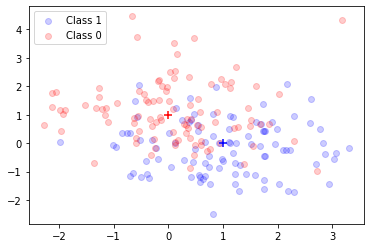

In [4]:
plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[0], m1[1], marker = '+', s = 80, c = "blue")
plt.scatter(m0[0], m0[1], marker = '+', s = 80, c = "red")

plt.legend()
plt.show()

### Part I: 1. KNN class

In [5]:
import traceback

class KNN:
    def __init__(self, traindata, Ytrain):
        self.traindata = traindata
        self.Ytrain = Ytrain
    
    def get_euclidean_distance(self, testdata, k):
        eucl_dist = []
        point_to_eucl_dist_mapping = {}
        for x, y, z in zip(self.traindata[:,0], self.traindata[:,1], self.Ytrain):
            dist = math.sqrt((x-testdata[0])**2+(y-testdata[1])**2)
            eucl_dist.append(dist)
            point_to_eucl_dist_mapping.update({dist:(x,y,z)})
        closest_dist_points = sorted(eucl_dist)[:k]
        return closest_dist_points, point_to_eucl_dist_mapping
    
    def predict(self, testdata, Ytest, k, prediction_type):
        pred = np.array([])
        prob_class_1 = np.array([])
        for test_point in testdata:
            closest_dist_points, point_to_eucl_dist_mapping = self.get_euclidean_distance([test_point[0], test_point[1]], k)
            point_pred = np.array([])
            for pt in closest_dist_points:
                point_pred = np.append(point_pred, np.array([point_to_eucl_dist_mapping[pt][2]]))
            point_prob = np.sum(point_pred)/k
            prob_class_1 = np.append(prob_class_1, np.array([point_prob]))
            if point_prob>0.5:
                pred = np.append(pred, np.array([1]))
            else:
                pred = np.append(pred, np.array([0]))
        
        if prediction_type == 'prob':
            return prob_class_1
        elif prediction_type == 'class':
            return pred
        else:
            raise TypeError("Mention the prediction type as 'prob' or 'class'")
    
    def accuracy(self, pred, Ytest):
        accuracy = np.sum(pred==Ytest)/len(Ytest)
        return accuracy
    
    def confusion_matrix(self, pred, Ytest):
        TP = sum((pred==1) & (Ytest==1))
        TN = sum((pred==0) & (Ytest==0))
        FP = sum((pred==1) & (Ytest==0))
        FN = sum((pred==0) & (Ytest==1))
        
        return np.matrix([[TP, FP],
                        [FN, TN]])

#### Method for predict
- Predict method returns class or probabilities based on the prediction type mentioned in the function call.

In [11]:
my_knn_mod = KNN(traindata, Ytrain)
pred = my_knn_mod.predict(testdata=testdata, Ytest=Ytest, k=5, prediction_type = 'class')

#### Method for accuracy
- $Accuracy = \frac{TP+TN}{TP+FP+FN+TN} = \frac{Correct Prediction}{Total Test Samples}$

In [12]:
my_knn_mod.accuracy(pred, Ytest)

0.7109

#### Method for confusion matrix
- Since there are only two classes here, below confusion matrx depicts the output of the confusion matrix method of KNN class

<img src="https://statisticallearning.org/img/conf-mat.png" width="60%">

In [13]:
my_knn_mod.confusion_matrix(pred, Ytest)

matrix([[3532, 1423],
        [1468, 3577]])

### Part I: 2. Handling distance ties and voting ties
- Distance Tie
    - When there is a distance tie, the algorithm randomly picks the top k items closes to the datapoint.
    - If the distance tie is not on the farthest K, the datapoints having distance ties and closer the test data than farthest K are included by default.
    - Since the distance calculated is euclidian distance, the probability of getting a distance tie is very low, but if the datapoints become infinite, chances of distance ties increases.
   
- Voting Tie
    - Whenever there are equal number of datapoints belonging to different classes, the probability value will become 0.5.
    - In such scenario, the algorithm will predict the class as 0 because the condition is that if prob is greater than 0.5, we predict it as class 1.
    - We can modify this probability threshold based on our analysis or prior knowledge about the data.

#### Part I: 3. Verification with sklearn KneighborsClassifier class
- The accuracy obtained by custom KNN class and the sklearn KneighborsClassifier class matches 100%.
- Note: sklearn uses different convention for confusion matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


 k: 1 ; Custom KNN Accuracy: 0.6585 ; Sklearn KNN Accuracy: 0.6585


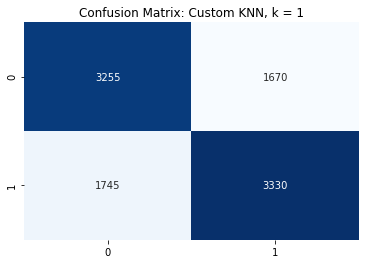

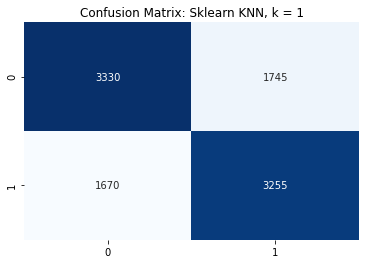


 k: 3 ; Custom KNN Accuracy: 0.7078 ; Sklearn KNN Accuracy: 0.7078


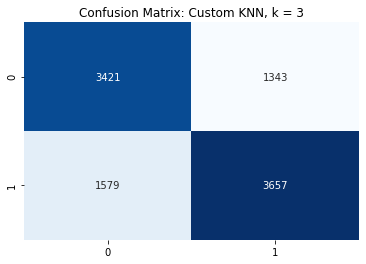

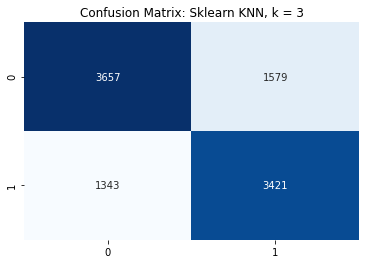


 k: 5 ; Custom KNN Accuracy: 0.7109 ; Sklearn KNN Accuracy: 0.7109


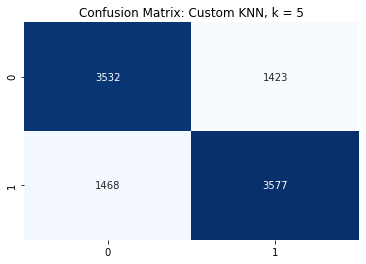

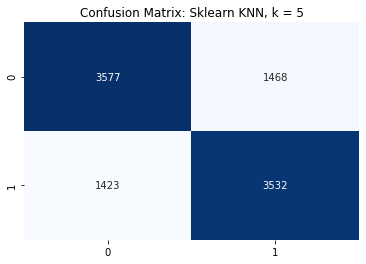

In [52]:
K = [1, 3, 5]


for k in K:
    # accuracy using custom KNN
    my_knn_mod = KNN(traindata, Ytrain)
    pred = my_knn_mod.predict(testdata=testdata, Ytest=Ytest, k=k, prediction_type = 'class')
    acc_custom_knn = my_knn_mod.accuracy(pred, Ytest)
    conf_mat_custom_knn = my_knn_mod.confusion_matrix(pred, Ytest)
    
    # accuracy using sklearn KNN class
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(traindata, Ytrain)
    acc_sklearn_knn = knn.score(testdata, Ytest)
    conf_mat_sklearn_knn = confusion_matrix(knn.predict(testdata), Ytest)
    print('\n k:', k, '; Custom KNN Accuracy:', acc_custom_knn, '; Sklearn KNN Accuracy:', acc_sklearn_knn)
    
    plt.title(f'Confusion Matrix: Custom KNN, k = {k}')
    sn.heatmap(conf_mat_custom_knn, annot=True,  fmt='.0f', cmap="Blues", cbar=False)
    plt.show()
    
    plt.title(f'Confusion Matrix: Sklearn KNN, k = {k}')
    sn.heatmap(conf_mat_sklearn_knn, annot=True,  fmt='.0f', cmap="Blues", cbar=False)
    plt.show()

## Example II

### Data Generation
Generate the 20 centers, 10 for each group.

In [60]:
csize = 10      
p = 2      
s = 1;      # sd for generating the centers within each class                    
m1 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[0, 1]] * csize)])

Generate training data.

In [61]:
n=100;  
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n)
id0 = np.random.randint(csize, size = n)


# sd for generating x  
s = np.sqrt(float(1)/5) 

traindata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
ytrain = np.concatenate(([1]*n, [0]*n))

In [66]:
n=5000;  
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n)
id0 = np.random.randint(csize, size = n)


# sd for generating x  
s = np.sqrt(float(1)/5) 

testdata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
ytest = np.concatenate(([1]*n, [0]*n))

### Visualization

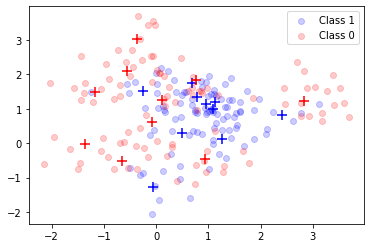

In [62]:
plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()